# Выбор локации для скважины

**Описание проекта:**
Добывающей компании «ГлавРосГосНефти» нужно решить, где бурить новую скважину.

**Цель проекта:**
Задача: на основе данных геологической разведки построить модель для определения региона, где добыча принесёт наибольшую прибыль

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков
- Строят модель и оценивают объём запасов
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины
- Прибыль равна суммарной прибыли отобранных месторождений

**Вводные параметры:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Описание данных согласно документации:**
* Данные геологоразведки трёх регионов находятся в файлах: 
 - geo_data_0.csv
 - geo_data_1.csv
 - geo_data_2.csv
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**План работы:**
1. Загрузка и подготовка данных
2. Обучение и проверка модели для каждого региона
3. Подготовка данных к расчёту прибыли
4. Выбор скважин с максимальными значениями предсказаний и рассчет прибыль
5. Посчитаем риски и прибыль для каждого региона(техника Bootstrap, средняя прибыль, 95%-й доверительный интервал и риск убытков)
6. Итоговый вывод

## Загрузка и подготовка данных

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display


In [3]:
df_1 = pd.read_csv('/data/geo_data_0.csv')
df_2 = pd.read_csv('/data/geo_data_1.csv')
df_3 = pd.read_csv('/data/geo_data_2.csv')

In [4]:
def basic_properties (data):
    print('Размер датасета:',data.shape)
    display(data.head(10))
    print('-' * 100, '\n')
    print(data.info())
    print('-' * 100, '\n')
    print('Всего явных дубликатов:', data.duplicated().sum())
    print('-' * 100, '\n')
    print('Количество пропусков:')
    display(data.isna().sum())
    print('Нулевые значения:')
    print(data.isnull().sum())
    print('-' * 100, '\n')
    print('Основная статистика:')
    display(data.describe())
    print('-' * 100, '\n')
    print('Корреляция Пирсона:')
    display(data.corr())
    print('-' * 100, '\n')
    print('Гистограммы распределения признаков:')
    data.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightGrey')

### Основные показатели по данным геологоразведки 1-ого региона

Размер датасета: (100000, 5)


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Нулевые значения:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------------------------------------------------------------------------------------------- 

Основная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


---------------------------------------------------------------------------------------------------- 

Корреляция Пирсона:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


---------------------------------------------------------------------------------------------------- 

Гистограммы распределения признаков:


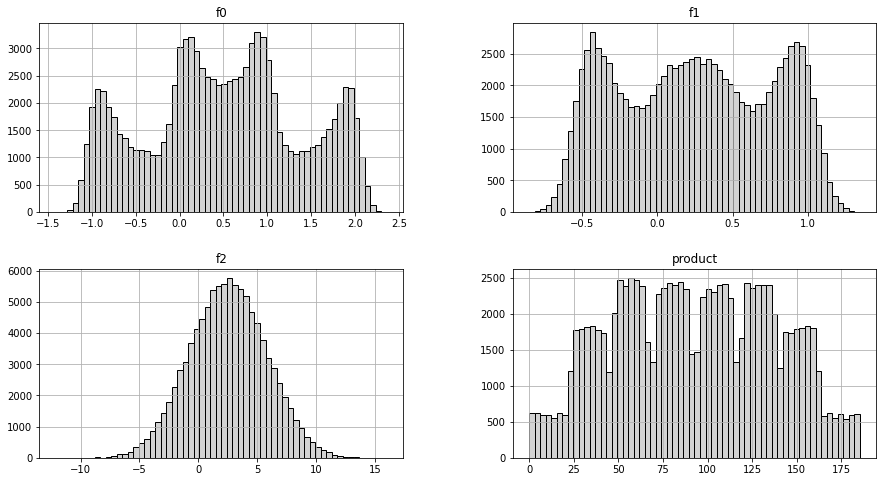

In [5]:
basic_properties(df_1)

1. Наблюдаем заметную корреляцию Пирсона признака f2 с объемами запасов нефти (product) - 0.483663
2. Распределения признаков на гистограммах симметричны - что является следствием синтетичности данных
3. В целом значения признаков f0, f1 не похожи на нормальное распределение, нужно будет привести их к нормальному

### Основные показатели по данным геологоразведки 2-ого региона

Размер датасета: (100000, 5)


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Нулевые значения:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------------------------------------------------------------------------------------------- 

Основная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


---------------------------------------------------------------------------------------------------- 

Корреляция Пирсона:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


---------------------------------------------------------------------------------------------------- 

Гистограммы распределения признаков:


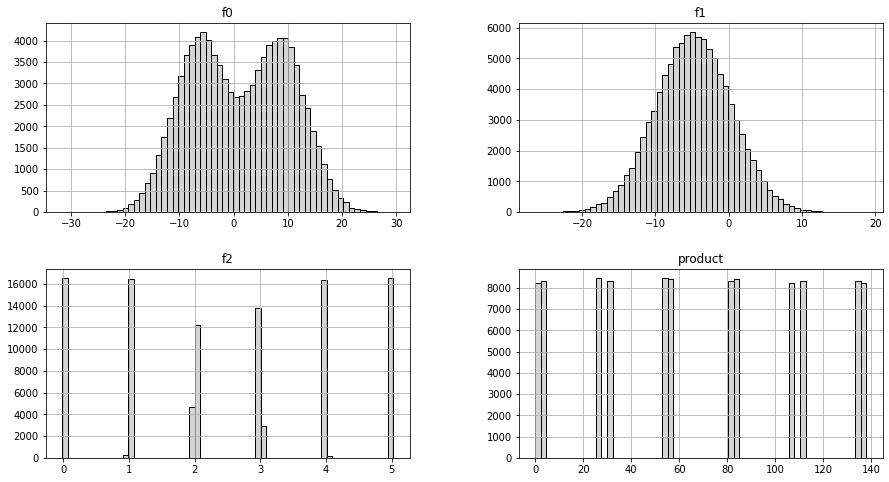

In [6]:
basic_properties(df_2)

1. Наблюдаем высокую корреляцию Пирсона признака f2 с объемами запасов нефти (product), 0.999397, можно сказать - прямую.
2. Показания среднего и медианы во всем признаках примерно равны, кроме целевого признака - медиана на 17% ниже по показателю чем среднее
3. В целом значения признаков f0, f2 не похожи на нормальное распределение, нужно будет привести их к нормальному
4. Распределения признаков на гистограммах снова симметричны - что является следствием синтетичности данных

### Основные показатели по данным геологоразведки 3-ого региона

Размер датасета: (100000, 5)


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Нулевые значения:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------------------------------------------------------------------------------------------- 

Основная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


---------------------------------------------------------------------------------------------------- 

Корреляция Пирсона:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


---------------------------------------------------------------------------------------------------- 

Гистограммы распределения признаков:


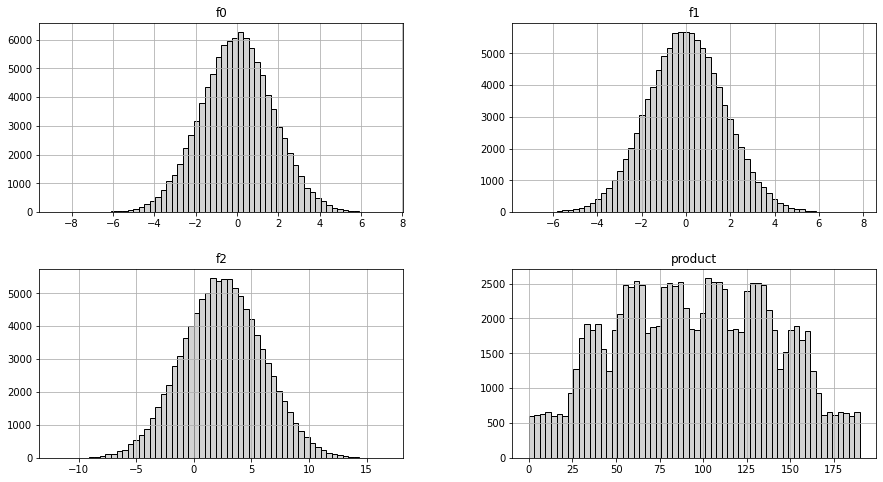

In [7]:
basic_properties(df_3)

1. Наблюдаем заметную корреляцию Пирсона признака f2 с объемами запасов нефти (product) - 0.445871
2. Распределения признаков на гистограммах симметричны - что является следствием синтетичности данных
3. В этом регионе признаки имеют нормальное распределение значений

### Удаление ненужного столбца

Во всех датафреймах удалим столбец id - он не влияет на исследование:

In [8]:
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)
df_3 = df_3.drop(['id'], axis=1)

### Вывод:
1. Данные не содержат дубликатов, пропусков, нарушений хорошего стиля, в целом, изначально хорошо подготовлены
2. Удален столбец 'id' во всех трех датафреймах, т к не несет нужной информации доля исследования
3. Распределения признаков на гистограммах симметричны - что является следствием синтетичности данных
4. Наиболее высокая корреляция Пирсона наблюдается по признаку f2  с объемами запасов нефти (product) во всех регионах, во 2ом регионе прямая зависимость- 0.999397
5. в 1ом и 2ом регионе признаки распределены отлично от нормального распределения, в 3ем регионе - у признаков нормальное распределение.


## Обучение и проверка модели

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [9]:
target_1 = df_1['product']
features_1 = df_1.drop('product', axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
features_1, target_1, test_size=0.25, random_state=12345)

model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
    
prediction_valid_1 = model_1.predict(features_valid_1)

    
avg_predicted_volume_1 = prediction_valid_1.mean()
rmse_1 = mean_squared_error(target_valid_1, prediction_valid_1, squared=False)  
    
print('Для 1ого региона:') 
print('Средний объем прогнозируемого сырья:', avg_predicted_volume_1)
print('RMSE:', rmse_1)


Для 1ого региона:
Средний объем прогнозируемого сырья: 92.59256778438035
RMSE: 37.5794217150813


In [10]:
target_2 = df_2['product']
features_2 = df_2.drop('product', axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
features_2, target_2, test_size=0.25, random_state=12345)

model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
    
prediction_valid_2 = model_2.predict(features_valid_2)
prediction_full_2 = model_2.predict(features_2)
    
avg_predicted_volume_2 = prediction_valid_2.mean()
rmse_2 = mean_squared_error(target_valid_2, prediction_valid_2, squared=False)  
    
print('Для 2ого региона:') 
print('Средний объем прогнозируемого сырья:', avg_predicted_volume_2)
print('RMSE:', rmse_2)


Для 2ого региона:
Средний объем прогнозируемого сырья: 68.728546895446
RMSE: 0.893099286775617


In [11]:
target_3 = df_3['product']
features_3 = df_3.drop('product', axis=1)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
features_3, target_3, test_size=0.25, random_state=12345)

model_3 = LinearRegression()
model_3.fit(features_train_3, target_train_3)
    
prediction_valid_3 = model_3.predict(features_valid_3)
prediction_full_3 = model_3.predict(features_3)
    
avg_predicted_volume_3 = prediction_valid_3.mean()
rmse_3 = mean_squared_error(target_valid_3, prediction_valid_3, squared=False)  
    
print('Для 3eго региона:') 
print('Средний объем прогнозируемого сырья:', avg_predicted_volume_3)
print('RMSE:', rmse_3)


Для 3eго региона:
Средний объем прогнозируемого сырья: 94.96504596800489
RMSE: 40.02970873393434


### Вывод:
* Как предполагалось, во 2ом регионе показатель RMSE (0.893) выше всего, это связано скорее всего с прямой корреляцией по признаку f2, которую выявили ранее. 
* Самый низкий показатель RMSE (37.57) в 1 регионе
* Средний объем прогнозируемого по валидационной выборке сырья больше у 1(92.59) и 3(94.96) регионов, у второго заметно ниже - (68.72), но это не основной показатель, посмотрим данные на лучших 200 скважинах

## Подготовка к расчёту прибыли

**Создадим необходимые переменные для расчета бизнес-метрик:**
* OBJECTS - 500 - точки скважин в каждом регионе
* SELECTED_OBJECTS - 200 шт - лучшие точки региона для разработки 
* BUDGET — 10 млрд рублей - бюджет на разработку скважин в регионе
* cost_one_well - стоимость разработки одной скважины
* revenue_1000_barrels - 450 тыс рублей - доход с одной тысячи баррелей
* damages_threshold - 2.5% - пороговое значение вероятности убытков  

In [12]:
OBJECTS = 500
SELECTED_OBJECTS = 200
BUDGET = 10_000_000_000
cost_one_well = BUDGET /SELECTED_OBJECTS
REVENUE_1000_BARRELS = 450_000
damages_threshold = 0.025
print('Стоимость разработки одной скважины: %.0f'%cost_one_well, 'рублей')

Стоимость разработки одной скважины: 50000000 рублей


**Рассчитаем средний объем сырья в каждом регионе по изначальным данным:**

In [13]:
volume_product_1 = df_1['product'].mean()
volume_product_2 = df_2['product'].mean()
volume_product_3 = df_3['product'].mean()
print('Средний объем сырья в 1ом регионе по предоставленным данным: %.2f'%volume_product_1)
print('Средний объем сырья во 2ом регионе по предоставленным данным: %.2f'%volume_product_2)
print('Средний объем сырья в 3ем регионе по предоставленным данным: %.2f'%volume_product_3)

Средний объем сырья в 1ом регионе по предоставленным данным: 92.50
Средний объем сырья во 2ом регионе по предоставленным данным: 68.83
Средний объем сырья в 3ем регионе по предоставленным данным: 95.00


**Рассчитаем объем сырья для безубыточной разработки  1ой скважины и региона:**

In [14]:
perfect_volume_product =  BUDGET / (REVENUE_1000_BARRELS * SELECTED_OBJECTS)
perfect_volume_product_region = BUDGET / REVENUE_1000_BARRELS
print('Oбъем сырья для безубыточной разработки скважины: %.2f'%perfect_volume_product,'тыс. баррелей' )
print('Oбщий объем сырья для безубыточной разработки скважин в одном регионе: %.2f'%perfect_volume_product_region,'тыс. баррелей' )

Oбъем сырья для безубыточной разработки скважины: 111.11 тыс. баррелей
Oбщий объем сырья для безубыточной разработки скважин в одном регионе: 22222.22 тыс. баррелей


**Посмотрим сколько скважин в каждом регионе имеют объем сырья равный или больше пороговаого значения 111.11 тыс баррелей**

In [15]:
print(f'Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = {len(df_1.query("product >= 111.11")) / len(df_1):.2%}')
print(f'Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = {len(df_2.query("product >= 111.11")) / len(df_2):.2%}')
print(f'Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = {len(df_3.query("product >= 111.11")) / len(df_3):.2%}')


Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = 36.58%
Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = 16.54%
Доля скважин с объем сырья большим или равным 111.11 тыс баррелей в 1 регионе = 38.18%


200 скважин от 500 это 40%, в каждом регионе количество скважин с объем сырья большим или равным 111.11 тыс баррелей не достигает 40%

## Расчёт прибыли и рисков 

### Расчет среднего объема по предсказанным 200 лучшим скважинам

Переведем предсказания в объекты Series, отберем по 200 лучших скважин, расчитаем среднее: 

In [16]:
prediction_full_1 = pd.Series(model_1.predict(features_1))
prediction_full_2 = pd.Series(model_2.predict(features_2))
prediction_full_3 = pd.Series(model_3.predict(features_3))


In [17]:
print("Регион 1:", prediction_full_1.sort_values(ascending=False)[:200].mean())
print("Регион 2:", prediction_full_2.sort_values(ascending=False)[:200].mean())
print("Регион 3:", prediction_full_3.sort_values(ascending=False)[:200].mean())

Регион 1: 163.2177352995591
Регион 2: 139.16229068572267
Регион 3: 156.26428434380662


В первом регионе самый высокий показатель по предсказанным 200 скважинам - 163.21


### Напишем функцию для расчета выручки:

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [18]:
def profit(target, probabilities, count, REVENUE_1000_BARRELS, BUDGET):
    probs_sorted = probabilities.sort_values(ascending=False).head(count)
    selected = target[probs_sorted.index][:count]
    profit = selected.sum() * REVENUE_1000_BARRELS - BUDGET
    return profit

def risk_of_loss (df):
    return (df < 0).mean() * 100

* Выбрали скважины с максимальными значениями предсказаний.
* Просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитали прибыль для полученного объёма сырья.

### Расчитаем выручку по всем регионам:

Для 1ого региона:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: 431092313.50 рублей.
Доверительный интервал лежит между -70541767.30 - 979019659.05 рублей.
Вероятность убытка в 1ом регионе: 5.1


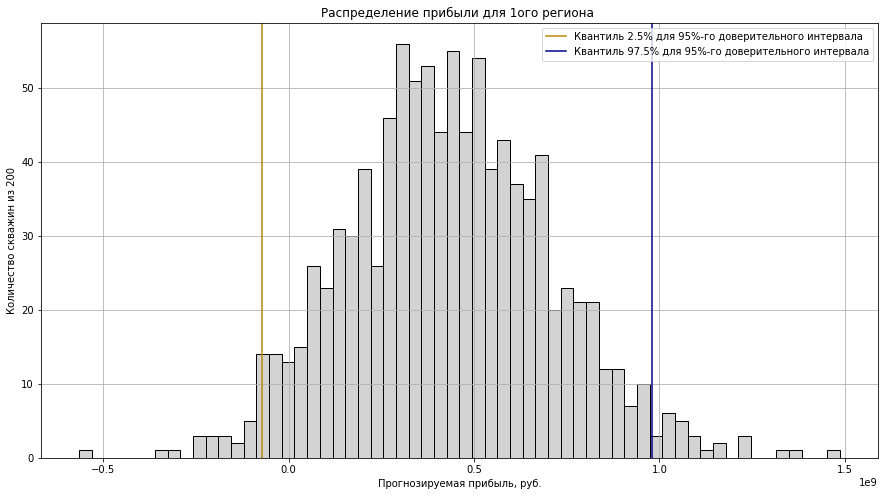

In [19]:
state = np.random.RandomState(12345)

values_1 = []
    
for _ in range(1000):
    target_subsample = target_1.sample(n=objects, replace=True, random_state=state)
    probs_subsample = prediction_full_1[target_subsample.index]
    sample_revenue = profit(target_subsample, probs_subsample, SELECTED_OBJECTS, REVENUE_1000_BARRELS, BUDGET)
    values_1.append(sample_revenue)
        
values_1 = pd.Series(values_1)
mean_1 = values_1.mean()
    
lower_1 = values_1.quantile(0.025)
upper_1 = values_1.quantile(0.975)    
     
print('Для 1ого региона:')
print(f'Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: {mean_1:.2f} рублей.')
print(f'Доверительный интервал лежит между {lower_1:.2f} - {upper_1:.2f} рублей.')
print(f'Вероятность убытка в 1ом регионе: {risk_of_loss(values_1)}')

values_1.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightGrey')
plt.grid(True)
plt.axvline(values_1.quantile(0.025), color='DarkGoldenRod')
plt.axvline(values_1.quantile(0.975), color='DarkBlue')
plt.legend(['Квантиль 2.5% для 95%-го доверительного интервала', 
                'Квантиль 97.5% для 95%-го доверительного интервала'])
plt.xlabel('Прогнозируемая прибыль, руб.')
plt.ylabel('Количество скважин из 200')
plt.title('Распределение прибыли для 1ого региона ')
plt.show()

Для 2ого региона:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: 450071682.61 рублей.
Доверительный интервал лежит между 44596630.49 - 830796301.52 рублей.
Вероятность убытка в 1ом регионе: 1.0


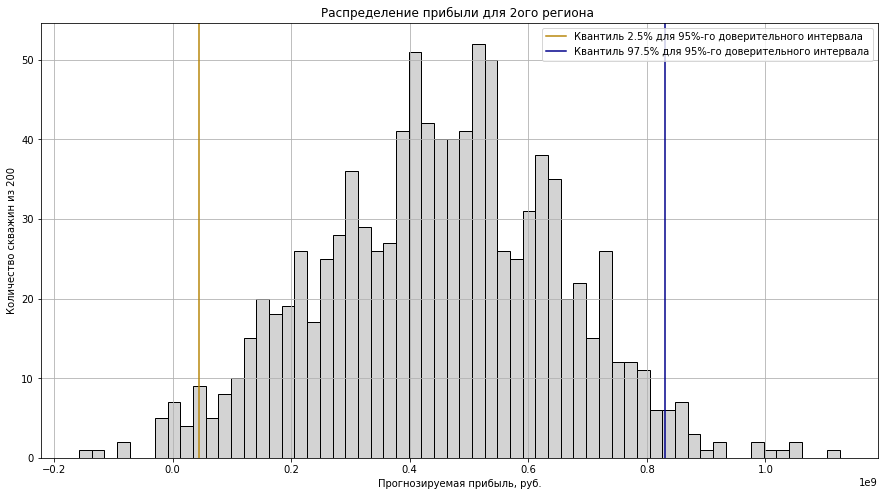

In [20]:
values_2 = []
    
for _ in range(1000):
    target_subsample = target_2.sample(n=objects, replace=True, random_state=state)
    probs_subsample = prediction_full_2[target_subsample.index]
    sample_revenue = profit(target_subsample, probs_subsample, SELECTED_OBJECTS, REVENUE_1000_BARRELS, BUDGET)
    values_2.append(sample_revenue)
        
values_2 = pd.Series(values_2)
mean_2 = values_2.mean()
    
lower_2 = values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)    
     
print('Для 2ого региона:')
print(f'Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: {mean_2:.2f} рублей.')
print(f'Доверительный интервал лежит между {lower_2:.2f} - {upper_2:.2f} рублей.')
print(f'Вероятность убытка в 1ом регионе: {risk_of_loss(values_2)}')

values_2.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightGrey')
plt.grid(True)
plt.axvline(values_2.quantile(0.025), color='DarkGoldenRod')
plt.axvline(values_2.quantile(0.975), color='DarkBlue')
plt.legend(['Квантиль 2.5% для 95%-го доверительного интервала', 
                'Квантиль 97.5% для 95%-го доверительного интервала'])
plt.xlabel('Прогнозируемая прибыль, руб.')
plt.ylabel('Количество скважин из 200')
plt.title('Распределение прибыли для 2ого региона ')
plt.show()

Для 3ого региона:
Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: 392180188.43 рублей.
Доверительный интервал лежит между -148308503.90 - 884150739.87 рублей.
Вероятность убытка в 1ом регионе: 8.3


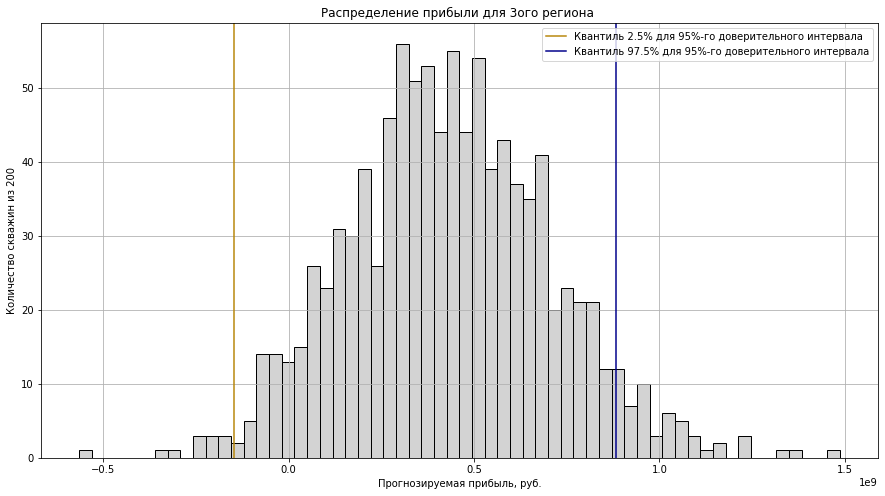

In [21]:
values_3 = []
    
for _ in range(1000):
    target_subsample = target_3.sample(n=objects, replace=True, random_state=state)
    probs_subsample = prediction_full_3[target_subsample.index]
    sample_revenue = profit(target_subsample, probs_subsample, SELECTED_OBJECTS, REVENUE_1000_BARRELS, budget)
    values_3.append(sample_revenue)
        
values_3 = pd.Series(values_3)
mean_3 = values_3.mean()
    
lower_3 = values_3.quantile(0.025)
upper_3 = values_3.quantile(0.975)    
     
print('Для 3ого региона:')
print(f'Средняя прибыль с 200 лучших скважин, отобраных по предсказанию: {mean_3:.2f} рублей.')
print(f'Доверительный интервал лежит между {lower_3:.2f} - {upper_3:.2f} рублей.')
print(f'Вероятность убытка в 1ом регионе: {risk_of_loss(values_3)}')

values_1.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightGrey')
plt.grid(True)
plt.axvline(values_3.quantile(0.025), color='DarkGoldenRod')
plt.axvline(values_3.quantile(0.975), color='DarkBlue')
plt.legend(['Квантиль 2.5% для 95%-го доверительного интервала', 
                'Квантиль 97.5% для 95%-го доверительного интервала'])
plt.xlabel('Прогнозируемая прибыль, руб.')
plt.ylabel('Количество скважин из 200')
plt.title('Распределение прибыли для 3ого региона ')
plt.show()

### Определение региона для разработки

Соберем все полученые метрики в таблицу и сравним регионы:

In [22]:
result_df = pd.DataFrame(index=['Средняя прогнозируемая прибыль по лучшим 200 скважинам, млн.руб',
                                'Общий запас сырья по лучшим 200 скважинам, тыс.баррелей','Вероятность убытка, %'], 
                         columns=['1ый регион','2ой регион','3ий регион'])
result_df['1ый регион'] = '431.09', '163.21', '5.1'
result_df['2ой регион'] = '472.21', '139.16', '1.5'
result_df['3ий регион'] = '372.77', '156.26', '8.2'
result_df

,1ый регион,2ой регион,3ий регион
"Средняя прогнозируемая прибыль по лучшим 200 скважинам, млн.руб",431.09,472.21,372.77
"Общий запас сырья по лучшим 200 скважинам, тыс.баррелей",163.21,139.16,156.26
"Вероятность убытка, %",5.1,1.5,8.2


Наилучший показатель по прогнозируемой выручке у региона №2, так же у этого региона наименьшая вероятность убытка - 1.5%. Два других региона не прошли порог вероятности убытка в 2.5%, поэтому, несмотря на меньшие запасы сырья по сравнению с 1 и 3 регионами, вероятность эффективной и прибыльной разработки выше у 2 ого региона.

### Итоговый вывод
1. Данные не содержат дубликатов, пропусков, нарушений хорошего стиля, в целом, изначально  хорошо подготовлены
2. Удален столбец 'id' во всех трех датафреймах, т к не несет нужной информации доля исследования
3. Распределения признаков на гистограммах симметричны - что является следствием синтетичности данных
4. Наиболее высокая корреляция Пирсона наблюдается по признаку f2 с объемами запасов нефти (product) во всех регионах, во 2ом регионе прямая зависимость- 0.999397
5. В 1ом и 2ом регионе признаки распределены отлично от нормального распределения, в 3ем регионе - у признаков нормальное распределение.
6. Как предполагалось, во 2ом регионе показатель RMSE (0.893) выше всего, это связано скорее всего с прямой корреляцией по признаку f2, которую выявили ранее.
7. Самый низкий показатель RMSE (37.57) в 1 регионе
8. Средний объем прогнозируемого по валидационной выборке сырья больше у 1(92.59) и 3(94.96) регионов, у второго заметно ниже - (68.72)
9. Расчитали выручку и риск убыточности по всем регионам


|метрики|1ый регион|2ой регион|3ий регион|
|--------|---------|-----------|----------|
|Средняя прогнозируемая прибыль по лучшим 200 скважинам, млн.руб|	431.09|	472.21|	372.77|
|Общий запас сырья по лучшим 200 скважинам, тыс.баррелей|	163.21|	139.16|	156.26|
|Вероятность убытка, %|	5.1|1.5|	8.2|

**10. Наилучший показатель по прогнозируемой выручке у региона №2, так же у этого региона наименьшая вероятность убытка - 1.5%. Два других региона не прошли порог вероятности убытка в 2.5%, поэтому, несмотря на меньшие запасы сырья по сравнению с 1 и 3 регионами, вероятность эффективной и прибыльной разработки выше у 2 ого региона.**
